<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DataFrames" data-toc-modified-id="DataFrames-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>DataFrames</a></span></li><li><span><a href="#Loops-and-Looping" data-toc-modified-id="Loops-and-Looping-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loops and Looping</a></span><ul class="toc-item"><li><span><a href="#Step-1:-Convert-HTML" data-toc-modified-id="Step-1:-Convert-HTML-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Step 1: Convert HTML</a></span></li><li><span><a href="#Step-2:-Write-function-to-extract-data" data-toc-modified-id="Step-2:-Write-function-to-extract-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Step 2: Write function to extract data</a></span></li></ul></li><li><span><a href="#Extra:-Parallelization" data-toc-modified-id="Extra:-Parallelization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extra: Parallelization</a></span></li><li><span><a href="#Homework" data-toc-modified-id="Homework-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Homework</a></span></li></ul></div>

Hopefully you now understand the basics of extracting information from EDGAR filings.
If you aren't an expert yet, don't worry that is to be expected.
As someone who has spent almost a decade doing it, I don't think it ever gets much easier.

The purpose of this last step is to take our small algorithm which extracts information from a filing, and loop over all the filings we might care about to extract the data from all of them.
To do this, I use the following execution flow:

  1. Get list of filings to be extracted into a pandas DataFrame.
  1. Loop over all filings:
     1. Call extract function on dataframe row
     1. Format return data in dictionary, with unique identifier for that row (UID keys)
     1. Add formatted return data to an aggregating list
  1. Pass list of dictionary results to a DataFrame
  1. Write DataFrame to disk.
  
It's pretty simple, so we're going to set up some convenience functions to automate most of it for us.
The hard part is debugging our extraction function, the rest is just fun times.

# DataFrames

Documentation: [https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)

Pandas is quickly becoming the standard go to library for data manipulation.
It is basically an amazingly designed wrapper for numpy arrays, so all the numpy/scipy/scikitlearn tools work quite well with DataFrames.

A DataFrame is just an excel spreadsheet, or a SAS dataset.
You can have multiple DataFrames in memory as variables like we used with lists or dictionaries before.

DataFrames have an index, and columns of data.
The index can get tricky, so we'll mostly ignore it for now.

If you remember, the indices that pyEDGAR returns are dataframes.
So let's load one of those up and play with it.

First, import pandas as `pd`, because that's what everyone does.
[Seriously, everyone](https://github.com/search?q=import+pandas+as+pd&type=Code).

In [ ]:
import pandas as pd

Now, grab the index of all Proxy statements.

In [ ]:
from pyedgar import EDGARIndex
idx = EDGARIndex()

# Ignore the query part for now
df = idx['DEF14A'].query('filedate.dt.year > 1995')

Now, let's take a look at the DataFrame. \
Do this.\
A lot.

In [ ]:
df.head()

`df.head(N)` and `df.tail(N)` show the first and last N rows.

We can also do things like count non-missing (`.count()`), describe, and take means of the data:

In [ ]:
df.count()

In [ ]:
df.describe()

Where'd the columns go?
Well they are all strings or dates except CIK, so describe calculated the summary stats for all numeric variables, and ignored the rest.

In [ ]:
df.describe(include='all')

Apparently ICAHN CARL has filed a lot of Proxys.
Let's find out what that means by [slicing](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html).

In [ ]:
# Make a selector, by using the special string functions, accessed by df.COLUMNAME.str.(<--hit tab)
sel = df.name.str.contains('ICAHN\s*CARL')
sel.head()

Selectors are a column of True/False values.
They are used to select which rows you want to keep, where the True values are kept and False are discarded:

In [ ]:
df[sel].head()

Note that we called `.head()` on the `df[sel]`, which is because that passed back a DataFrame with only the rows we asked for.

Usually, I don't make `sel` variables, I just pass the selector into `df[]` directly:

In [ ]:
df[df.name.str.contains('ICAHN\s*CARL')].head()

If we just want some columns, we can pass in a name or list too:

In [ ]:
df['cik']

In [ ]:
df[['cik', 'accession']].head()

I am too lazy to type brackets, so instead I use the handy split trick (note, only works if your column names don't have spaces):

In [ ]:
'cik accession'.split() == ['cik', 'accession']

In [ ]:
df['cik accession'.split()].head()

Lastly, putting both row and column selecting together requires a little change, specifically the addition of `.loc`.
Just memorize it, sorry.

In [ ]:
# .loc is always rows, columns
df.loc[df.name.str.contains('ICAHN\s*CARL'), 'cik accession name'.split()].head()

Now because we're going to be playing with DataFrames a lot, I've written up some convenience functions.
They are located in import.ipynb.

This is at the top of every one of my notebooks:

In [ ]:
%run imports.ipynb

In [ ]:
df.C('*i*')

This is convenient because a) you don't have to remember your imports, and b) it shows the version, so you can see if it changed as maybe a reason your notebook results may have changed.

Included in this import file (which you can look through) are three functions that I use quite a bit.

<br/>

`linkhead` adds EDGAR links to your dataframe, so you can open them quickly.
 - `linkhead(df, n=5, title='', fields=None, cik='cik', accession='accession', return_df=False)`
  
<br/>

`C` splits strings (C('cik accession') == 'cik accession'.split(), but if you pass in a DataFrame too, it will do column completion:
  - `C(df, 'ci*') == 'cik'`
  - `C(df, '*i*) == ['cik', 'filedate', 'accession']`
  - And lastly, I've monkeypatched it onto pandas, so you can call `df.C('*i*')`

<br/>

`timehist` plots a histogram by year. Pretty simple.
   - `timehist(dtseries_or_df, time_variable='year', y_tic_number=4, x_tic_skip=0, width=.9, ax=None, skip_retick=False, label=None)`
  

In [63]:
linkhead(df)

cik,name,form,filedate,accession,links
20,K TRON INTERNATIONAL INC,DEF 14A,1996-03-28,0000893220-96-000499,Index Raw
20,K TRON INTERNATIONAL INC,DEF 14A,1997-03-20,0000893220-97-000578,Index Raw
20,K TRON INTERNATIONAL INC,PRE 14A,1998-03-10,0000893220-98-000530,Index Raw
20,K TRON INTERNATIONAL INC,DEF 14A,1998-03-23,0000893220-98-000579,Index Raw
20,K TRON INTERNATIONAL INC,DEF 14A,1999-03-30,0000893220-99-000383,Index Raw


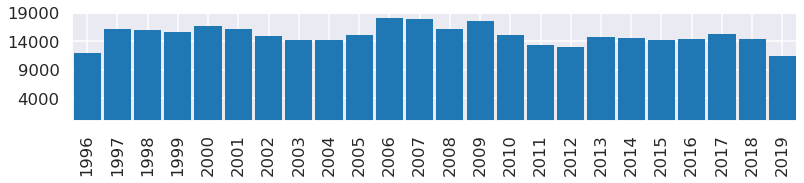

In [64]:
timehist(df.filedate)

All of my data creation notebooks have those time-histogram plots all over them.
It's a great way to quickly sanity check your sample.

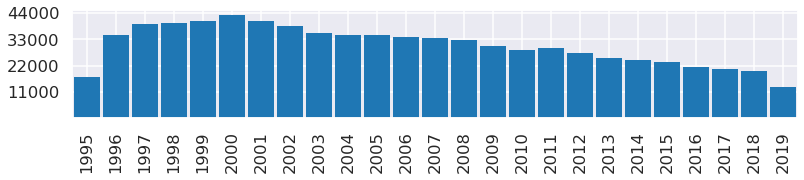

In [65]:
# Example: all 10-Qs, plotted.
ax=timehist(idx['10-Q'].filedate)

Did you know there was that great of a decline in filings over time?

Now you do, because of one line of code.

10-Ks and 10-Qs over time


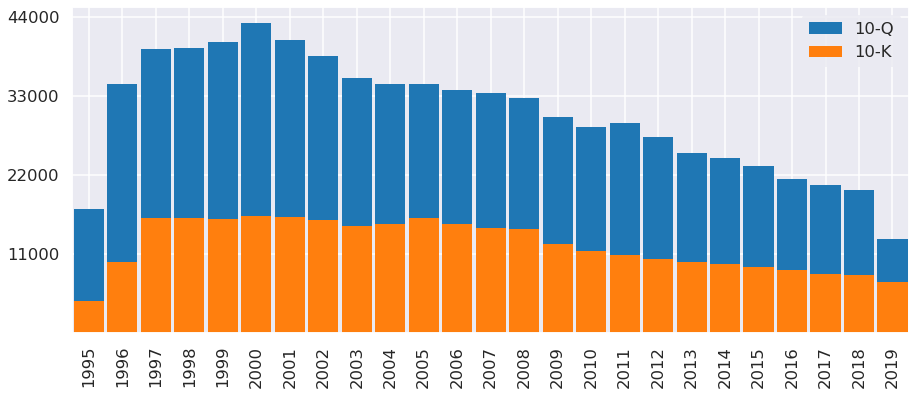

In [66]:
# Now let's overlay the 10-Ks
ax = timehist(idx['10-Q'].filedate, label='10-Q', figsize=(15, 6))
timehist(idx['10-K'].filedate, ax=ax, skip_retick=True, label='10-K')
ax.legend(loc=0)
print("10-Ks and 10-Qs over time")

But enough with the fun graphs, back to work.

There's lots of pandas to get good at, the documentation is really top notch.

# Loops and Looping

In [ ]:
# Import the filing
from pyedgar import Filing

We're going to take that DataFrame above, and loop over it.
StackExchange has strong opinions about how looping over DataFrames is bad and slow, but we don't care.

In [ ]:
for index, row in df.iterrows():
    print(index)
    print(row)
    break

Yes, that's always how I start every loop of a DataFrame.
That's because now I can do this:

In [ ]:
def extract_from_row(row):
    print(row)

extract_from_row(row)

Now we have a function where we will put our extraction code.
So we would test all the filings like this:

In [ ]:
return_list = []

for index, row in df.iterrows():
    try:
        return_list.append(extract_from_row(row))
    except:
        # I know an except ALL is bad, but we want our code to not crash after 2 hours
        logger.exception("Error on row %r", row)
        
    # We don't actually have anything, so let's not run the whole loop
    break

Now to write the `extract_from_row` code, I find it easier to develop it in a cell, then copy it up into the function above.

In [ ]:
# def extract_from_row(row): # Swap these comments to make it a function
if True:
    filing = Filing(row.cik, row.accession)
    try:
        html = filing.documents[0]['full_text']
    except FileNotFoundError:
        # We could tell it to try again over HTTP:
        #filing = Filing(row.cik, row.accession)
        #filing._local_cache = False
        #html = filing.documents[0]['full_text']
        # but that's slow. For now, just ignore.
        raise Exception("Replace this with `return None` in function")

    print(html[:500])

Oh my, that's not HTML at all!
Well at least on my pull, that was a plaintext filing.
Oh EDGAR.

So our goal is to write an `extract_from_row` function which gets the data we want.

In this case, I'm going to just do some simple word-counts, but hopefully you can see how this could be any extracted information we might want.

## Step 1: Convert HTML

Step 1 is convert HTML to plaintext.
But how do we know if a filing is HTML?

Let's find out!
What I'm going to do is look through all the filings, and see how many tags exist in the first 10% of the document.
I can't just look for any tag, because some plain-text filings have `<PAGE>` and `<TABLE>` tags.
Realistically, in your own code just look for <p or <div tags, but this is a teaching opportunity.

In [ ]:
re_html_check = re.compile(r'<(?:p|div|tr|td|font|b)\b', re.I)

def extract_from_row(row, percent=10):
    filing = Filing(row.cik, row.accession)
    ret = {'cik': row.cik, 'accession': row.accession}
    try:
        html = filing.documents[0]['full_text']
    except FileNotFoundError:
        # Use some fancy dict functions for shorthand
        return {**ret, 'error': 'File Not Found'}
    
    # Otherwise, we have the filing.
    
    ret['length'] = len(html)
    ret['num_tags'] = len(re_html_check.findall(html, endpos=int(ret['length']/percent)))
    
    return ret

extract_from_row(row)

Cool, looks like that worked the first time &#128521;

Let's copy that loop code from up above, but add TQDM to it, which tracks progress:

In [ ]:
return_list = []

for index, row in tqdm(df.iterrows(), total=len(df)):
    try:
        return_list.append(extract_from_row(row))
    except:
        # I know an except ALL is bad, but we want our code to not crash after 2 hours
        logger.exception("Error on row %r", row)

Now we have our results, we can just throw it into a DataFrame:

In [ ]:
dfout = pd.DataFrame(return_list)
dfout.head()

If we want to look by year, we can merge our original sample back in:

In [ ]:
dfout = (pd.DataFrame(return_list)
           .merge(df, how='outer'))
dfout['year'] = dfout.filedate.dt.year
dfout[dfout.error.isnull()].tail()

What does that look like by year?

In [ ]:
dfout.groupby('year').num_tags.mean().to_frame()

Let's look at that by 0s and non-0s:

In [ ]:
(pd.crosstab(dfout.year, dfout.num_tags > 0)
   .assign(mean=dfout[dfout.num_tags>0].groupby('year').num_tags.mean()))

Looks like 100 might be a good cutoff.
Let's use that.

Let's write a function that takes in a filing, and returns the plaintext of its first document.

In [ ]:
from bs4 import BeautifulSoup

def get_text(filing, re_html_check=re.compile(r'<(?:p|div|tr|td|font|b)\b', re.I)):
    # Don't catch FileNotFound error here, let the caller catch it
    html = filing.documents[0]['full_text']
    
    num_tags = len(re_html_check.findall(html, endpos=int(len(html)/10)))
    
    if num_tags > 100:
        return BeautifulSoup(html, 'lxml').get_text()
    
    return html

In [ ]:
print(get_text(Filing(row.cik, row.accession))[:500])

## Step 2: Write function to extract data

Okay, so now we can convert any document to plaintext.

Let's just extract word-counts, because this is more about the looping and analysis than the fancy extraction.

In [ ]:
# Using the word finder from last homework
re_word_finder = re.compile(
    r'\b'                  # word-boundry, so match beginning or ends of words
    r"(?:[^\W\d_]|[-'’])+" # Add ’, which is not just single quote, but single end quote
    r'\b'                  # ending word-boundry
    , re.IGNORECASE
)

In [ ]:
def extract_from_row(row):
    filing = Filing(row.cik, row.accession)
    ret = {'cik': row.cik, 'accession': row.accession}
    try:
        text = get_text(filing)
    except FileNotFoundError:
        # Use some fancy dict functions for shorthand
        return {**ret, 'error': 'File Not Found'}
    
    # Otherwise, we have the filing.
    ret['num_words'] = len(re_word_finder.findall(text))
    
    return ret

In [ ]:
return_list = []

for index, row in tqdm(df.iterrows(), total=len(df)):
    try:
        return_list.append(extract_from_row(row))
    except:
        # I know an except ALL is bad, but we want our code to not crash after 2 hours
        logger.exception("Error on row %r", row)

That was easy, wasn't it?

Oh the delight of copy/paste.
The annoying thing is how long it's going to take, that's a problem we can solve slightly with better hardware, and parallelization.

This is beyond the scope of what I want to cover, but I've provided a parallel version below.

If you want to stop the above, click the black square up above.

In [ ]:
dfwc = pd.DataFrame(return_list)

In [ ]:
dfwc.head()

# Extra: Parallelization

In [ ]:
%run imports.ipynb

from pyedgar import Filing

from time import sleep

from ipywidgets import Output, IntProgress, HTML as wHTML

In [ ]:
import ipyparallel as ipp
IP_client = ipp.Client()
print(IP_client.ids)
IP_view = IP_client.load_balanced_view()

Now, we're going to use Notebook's %%px magic to run a cell in all those threads above we made.

In [ ]:
%%px --local

import re
from bs4 import BeautifulSoup
from pyedgar import Filing

def get_text(filing, re_html_check=re.compile(r'<(?:p|div|tr|td|font|b)\b', re.I)):
    # Don't catch FileNotFound error here, let the caller catch it
    html = filing.documents[0]['full_text']
    
    num_tags = len(re_html_check.findall(html, endpos=int(len(html)/10)))
    
    if num_tags > 100:
        return BeautifulSoup(html, 'lxml').get_text()
    
    return html

# Using the word finder from last homework
re_word_finder = re.compile(
    r'\b'                  # word-boundry, so match beginning or ends of words
    r"(?:[^\W\d_]|[-'’])+" # Add ’, which is not just single quote, but single end quote
    r'\b'                  # ending word-boundry
    , re.IGNORECASE
)

def extract_from_row(row):
    filing = Filing(row.cik, row.accession)
    ret = {'cik': row.cik, 'accession': row.accession}
    try:
        text = get_text(filing)
    except FileNotFoundError:
        # Use some fancy dict functions for shorthand
        return {**ret, 'error': 'File Not Found'}
    
    # Otherwise, we have the filing.
    ret['num_words'] = len(re_word_finder.findall(text))
    
    return ret

In [ ]:
async_result = IP_view.map(lambda x: extract_from_row(x[1]),
                           df.iterrows(),
                           chunksize=100,
                           ordered=False)

In [ ]:
queue_len = len(async_result.status)
tot_num = len(df)

txt = wHTML(value=f'Processing {queue_len} w/ {tot_num // queue_len} per')
prog = IntProgress(
        value=async_result.progress,
        min=0,
        max=len(async_result.status),
        step=1,
        description=f'Processing {queue_len} w/ {tot_num // queue_len} per:',
        bar_style='', # 'success', 'info', 'warning', 'danger' or ''
        orientation='horizontal'
    )
display(txt, prog)

while not async_result.done():
    prog.value = async_result.progress
    txt.value = (f'Processing {async_result.progress} of {queue_len} '
                 f'({100*async_result.progress/queue_len:7.2f}% @ {tot_num // queue_len} per)')
    sleep(10)

In [ ]:
dfwc = pd.DataFrame(async_result.result()).merge(df, how='outer')
dfwc['year'] = dfwc.filedate.dt.year

In [ ]:
dfwc.describe()

In [ ]:
dfwc.to_csv('data/word_count.csv.gz')

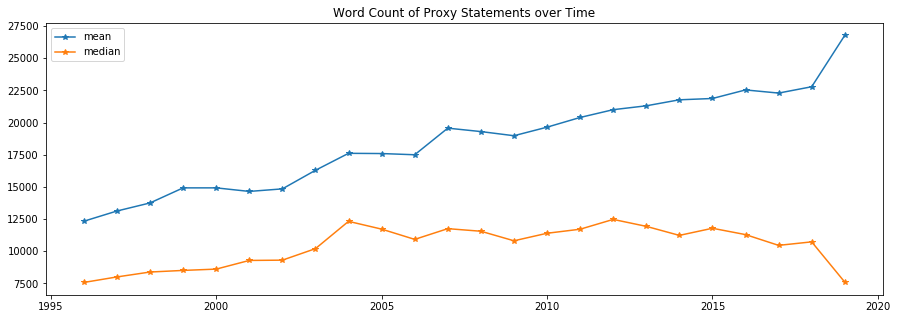

In [62]:
plt.plot(sorted(dfwc.year.unique()), dfwc.groupby('year').num_words.mean().sort_index(),
         label='mean', marker='*')
plt.plot(sorted(dfwc.year.unique()), dfwc.groupby('year').num_words.median().sort_index(),
         label='median', marker='*')
plt.title('Word Count of Proxy Statements over Time')
_ = plt.legend()

# Homework

Using the filing from above ([this one](https://www.sec.gov/Archives/edgar/data/1652044/000130817917000170/lgoog2017_def14a.htm)), read in the HTML and answer the following questions:



  1. How many words are in the filing?
  1. How many pages are in the filing?
  1. How many images are included in the filing?
  1. What are the different sections of the proxy statement? (hint: see the table of contents we found above).
  1. What are the top 5 people (by salary) paid at Google?
  1. *WITHOUT CODING*: Describe how you would go about extracting this information programatically.
     1. What format is this information in?
     1. Do you think it's repeatable for not-Google?
     1. Would you use HTML or plain text to get this information?
     1. Extra credit: Write out some [pseudo-code](https://www.vikingcodeschool.com/software-engineering-basics/what-is-pseudo-coding) for your approach, or just the steps in plain english.